In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import scipy.ndimage as ndimage
import xarray as xr

In [2]:
lat = np.linspace(-90, 90, 181)
lon = np.linspace(-180, 180, 361)

In [3]:
a = np.zeros((181, 361))
da = xr.DataArray(a, coords={'lat': lat, 'lon': lon})
da.sel(lat=slice(20, 40), lon=slice(130, 170)).values[:] = 5

In [4]:
def plot_da(da):
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, layout='constrained')
    fig.set_size_inches(14, 6)
    im = ax.contourf(da.lon, da.lat, da)
    ax.coastlines()
    plt.colorbar(im)
    
    

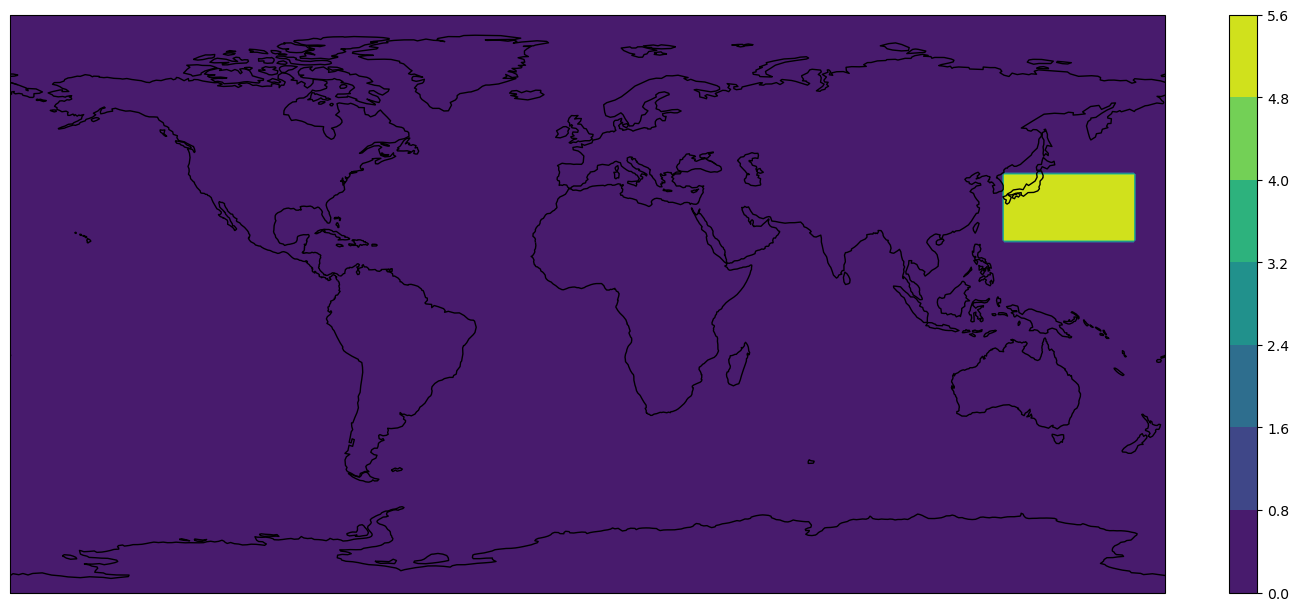

In [5]:
plot_da(da)

In [6]:
da1 = da.copy()
da1.values = ndimage.gaussian_filter(da.values, (45, 20), mode='wrap')

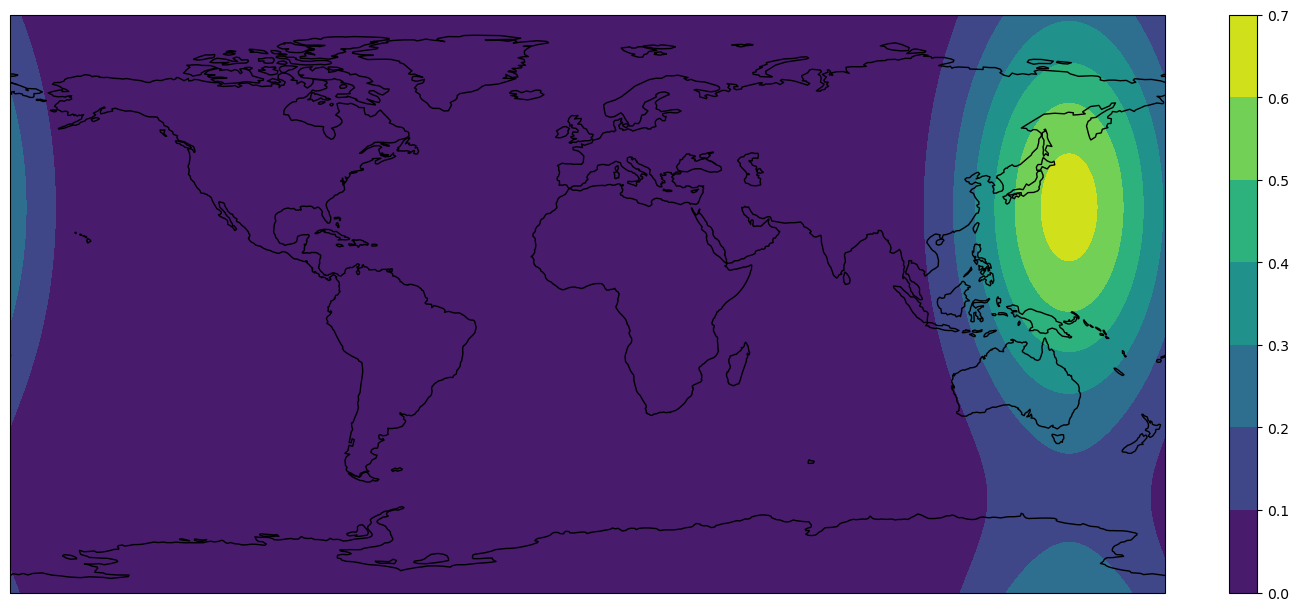

In [7]:
plot_da(da1)

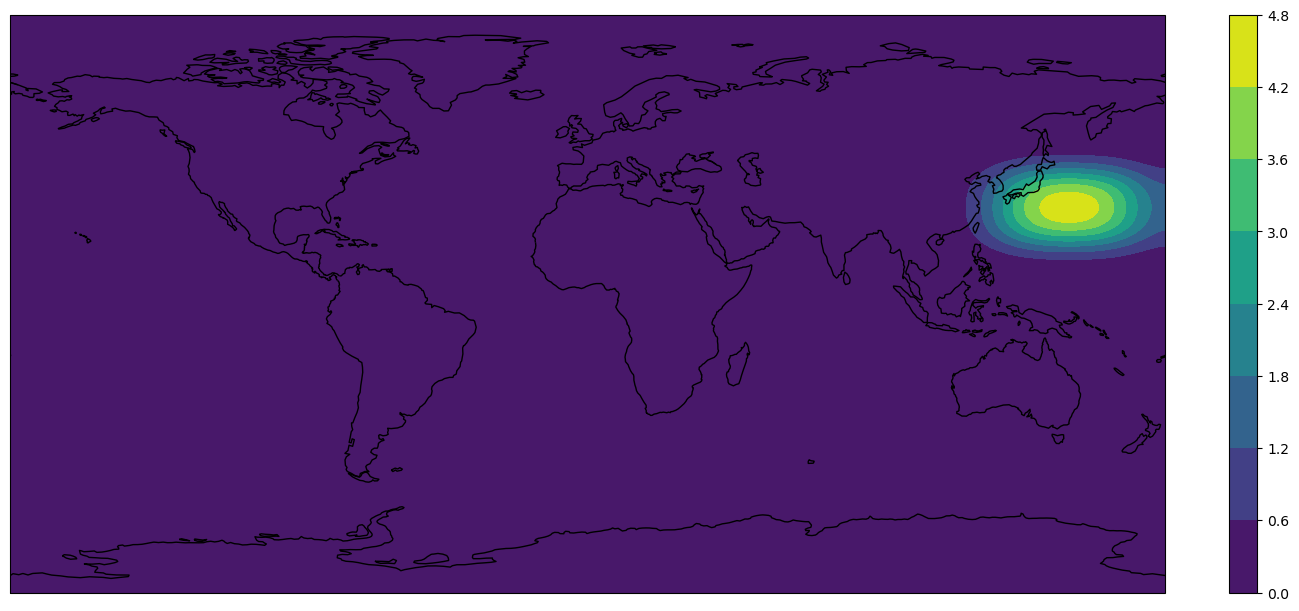

In [8]:
da2 = da.copy()
da2.values = ndimage.gaussian_filter1d(ndimage.gaussian_filter1d(da.values, 5, axis=0), 10, axis=1)
plot_da(da2)

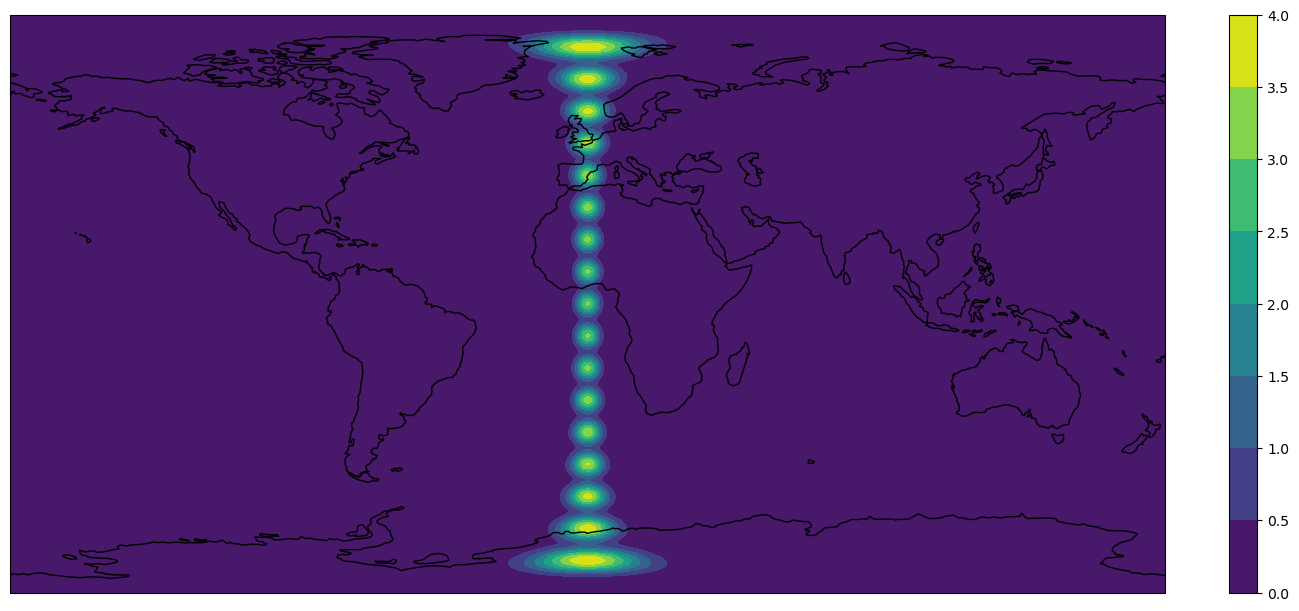

In [9]:
da3 = da.copy()
da3.values[:] = 0
for j in range(-80, 90, 10):
    da3.sel(lat=slice(j - 2.5, j + 2.5), lon=slice(-2.5, 2.5)).values[:] = 5
sigma = 2
for i, y in enumerate(da.lat.values):
    sigma_x = sigma / np.cos(np.pi * y / 180)
    if np.abs(y) > 89:
        continue
    da3.values[i] = ndimage.gaussian_filter1d(da3.values[i], sigma_x, mode='wrap') / np.cos(np.pi * y / 180) # think last division is NOT NEEDED, but instead it's an artefact of using smaller area sources at higher lats?
da3.values = ndimage.gaussian_filter1d(da3.values, sigma, axis=0)
plot_da(da3)

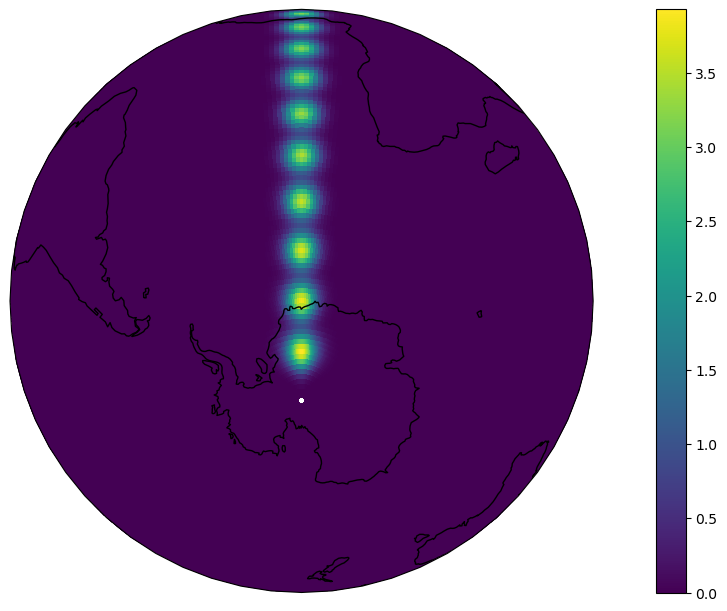

In [10]:
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.Orthographic(0, -70)}, layout='constrained')
    fig.set_size_inches(14, 6)
    im = ax.pcolormesh(da3.lon, da3.lat, da3, transform=ccrs.PlateCarree())
    ax.coastlines()
    plt.colorbar(im)

In [11]:
import iris

In [12]:
import iris.cube

In [13]:
iris.cube.Cube?

Init signature:
iris.cube.Cube(
    data,
    standard_name=None,
    long_name=None,
    var_name=None,
    units=None,
    attributes=None,
    cell_methods=None,
    dim_coords_and_dims=None,
    aux_coords_and_dims=None,
    aux_factories=None,
    cell_measures_and_dims=None,
    ancillary_variables_and_dims=None,
)
Docstring:     
A single Iris cube of data and metadata.

Typically obtained from :func:`iris.load`, :func:`iris.load_cube`,
:func:`iris.load_cubes`, or from the manipulation of existing cubes.

For example:

    >>> cube = iris.load_cube(iris.sample_data_path('air_temp.pp'))
    >>> print(cube)
    air_temperature / (K)               (latitude: 73; longitude: 96)
        Dimension coordinates:
            latitude                             x              -
            longitude                            -              x
        Scalar coordinates:
            forecast_period             6477 hours, bound=(-28083.0, 6477.0) hours
            forecast_reference_time 

In [42]:

from iris.coords import DimCoord
from iris.cube import Cube

import numpy as np

cs = iris.coord_systems.RotatedGeogCS(0, 0)
latitude = DimCoord(np.linspace(-89.5, 89.5, 180),
                    standard_name='latitude',
                    units='degrees',
                    coord_system=cs)
longitude = DimCoord(np.linspace(0.5, 359.5, 360),
                     standard_name='longitude',
                     units='degrees',
                     coord_system=cs)

latitude.guess_bounds()
longitude.guess_bounds()

cube = Cube(np.zeros((180, 360), np.float32),
            dim_coords_and_dims=[(latitude, 0),
                                 (longitude, 1)])

In [43]:
cube

Unknown (unknown),latitude,longitude
Shape,180,360
Dimension coordinates,,
latitude,x,-
longitude,-,x


In [45]:
cube.coord_system()

RotatedGeogCS(0.0, 0.0)

In [17]:
global_air_temp = iris.load_cube(iris.sample_data_path('air_temp.pp'))
rotated_psl = iris.load_cube(iris.sample_data_path('rotated_pole.nc'))


/home/markmuetz/anaconda3/envs/mcs_prime_env/lib/python3.10/site-packages/iris/fileformats/pp.py:1482: UserWarning: has_year_zero kwarg ignored for idealized calendars (always True)
  self._t1 = cftime.datetime(
/home/markmuetz/anaconda3/envs/mcs_prime_env/lib/python3.10/site-packages/iris/fileformats/pp.py:1516: UserWarning: has_year_zero kwarg ignored for idealized calendars (always True)
  self._t2 = cftime.datetime(
/home/markmuetz/anaconda3/envs/mcs_prime_env/lib/python3.10/site-packages/cf_units/__init__.py:411: UserWarning: has_year_zero kwarg ignored for idealized calendars (always True)
  dates = np.array([dt and dt.replace(microsecond=0) for dt in dates])


/home/markmuetz/anaconda3/envs/mcs_prime_env/lib/python3.10/site-packages/iris/fileformats/pp.py:1482: UserWarning: has_year_zero kwarg ignored for idealized calendars (always True)
  self._t1 = cftime.datetime(
/home/markmuetz/anaconda3/envs/mcs_prime_env/lib/python3.10/site-packages/iris/fileformats/pp.py:1516: UserWarning: has_year_zero kwarg ignored for idealized calendars (always True)
  self._t2 = cftime.datetime(
/home/markmuetz/anaconda3/envs/mcs_prime_env/lib/python3.10/site-packages/cf_units/__init__.py:411: UserWarning: has_year_zero kwarg ignored for idealized calendars (always True)
  dates = np.array([dt and dt.replace(microsecond=0) for dt in dates])
/home/markmuetz/anaconda3/envs/mcs_prime_env/lib/python3.10/site-packages/iris/coords.py:2045: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/home/markmuetz/anaconda3/envs/mcs_prime_env/lib/python3.10/site-packages/iris/coords.py:2045: UserWarning: Coordinate 'latitude' is n

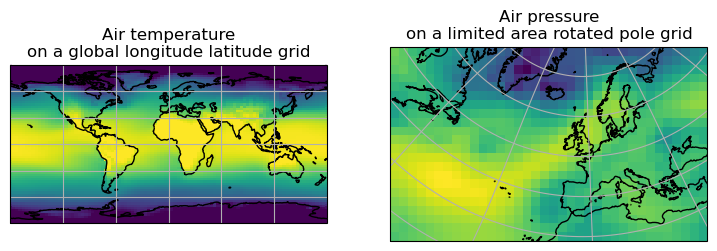

In [18]:
"""Plot regridded data."""

import matplotlib.pyplot as plt

import iris
import iris.plot as iplt

# Load the data.
global_air_temp = iris.load_cube(iris.sample_data_path("air_temp.pp"))
rotated_psl = iris.load_cube(iris.sample_data_path("rotated_pole.nc"))

plt.figure(figsize=(9, 3.5))

plt.subplot(1, 2, 1)
iplt.pcolormesh(global_air_temp, norm=plt.Normalize(260, 300))
plt.title("Air temperature\non a global longitude latitude grid")
ax = plt.gca()
ax.coastlines()
ax.gridlines()

plt.subplot(1, 2, 2)
iplt.pcolormesh(rotated_psl)
plt.title("Air pressure\non a limited area rotated pole grid")
ax = plt.gca()
ax.coastlines(resolution="50m")
ax.gridlines()

plt.show()

/home/markmuetz/anaconda3/envs/mcs_prime_env/lib/python3.10/site-packages/iris/fileformats/pp.py:1482: UserWarning: has_year_zero kwarg ignored for idealized calendars (always True)
  self._t1 = cftime.datetime(
/home/markmuetz/anaconda3/envs/mcs_prime_env/lib/python3.10/site-packages/iris/fileformats/pp.py:1516: UserWarning: has_year_zero kwarg ignored for idealized calendars (always True)
  self._t2 = cftime.datetime(
/home/markmuetz/anaconda3/envs/mcs_prime_env/lib/python3.10/site-packages/cf_units/__init__.py:411: UserWarning: has_year_zero kwarg ignored for idealized calendars (always True)
  dates = np.array([dt and dt.replace(microsecond=0) for dt in dates])
/home/markmuetz/anaconda3/envs/mcs_prime_env/lib/python3.10/site-packages/iris/coords.py:2045: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/home/markmuetz/anaconda3/envs/mcs_prime_env/lib/python3.10/site-packages/iris/coords.py:2045: UserWarning: Coordinate 'latitude' is n

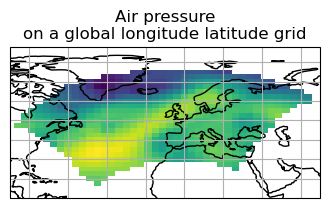

In [19]:
"""Interpolate using iris.analysis.Linear()."""

import matplotlib.pyplot as plt

import iris
import iris.analysis
import iris.plot as iplt

global_air_temp = iris.load_cube(iris.sample_data_path("air_temp.pp"))
rotated_psl = iris.load_cube(iris.sample_data_path("rotated_pole.nc"))

scheme = iris.analysis.Linear(extrapolation_mode="mask")
global_psl = rotated_psl.regrid(global_air_temp, scheme)

plt.figure(figsize=(4, 3))
iplt.pcolormesh(global_psl)
plt.title("Air pressure\non a global longitude latitude grid")
ax = plt.gca()
ax.coastlines()
ax.gridlines()
ax.set_extent([-90, 70, 10, 80])

plt.show()

In [25]:
cs = rotated_psl.coord_system()

In [26]:
type(cs)

iris.coord_systems.RotatedGeogCS

In [39]:
cube.coord_system(cs2)

TypeError: issubclass() arg 1 must be a class

In [30]:
cube.coord_system

RotatedGeogCS(0.0, 0.0)

In [168]:
from esmf_regrid.schemes import ESMFAreaWeighted

In [101]:

from iris.coords import DimCoord
from iris.cube import Cube

import numpy as np

cs = iris.coord_systems.GeogCS(6371229)
cs2 = iris.coord_systems.RotatedGeogCS(0, 0, ellipsoid=cs)
latitude = DimCoord(np.linspace(-89.5, 89.5, 180),
                    standard_name='latitude',
                    units='degrees',
                    coord_system=cs)
longitude = DimCoord(np.linspace(0.5, 359.5, 360),
                     standard_name='longitude',
                     units='degrees',
                     coord_system=cs)

latitude2 = DimCoord(np.linspace(-89.5, 89.5, 180),
                     standard_name='latitude',
                     units='degrees',
                     coord_system=cs2)
longitude2 = DimCoord(np.linspace(0.5, 359.5, 360),
                      standard_name='longitude',
                      units='degrees',
                      coord_system=cs2)

latitude.guess_bounds()
longitude.guess_bounds()
latitude2.guess_bounds()
longitude2.guess_bounds()

cube = Cube(np.zeros((180, 360), np.float32),
            dim_coords_and_dims=[(latitude, 0),
                                 (longitude, 1)])
cube2 = Cube(np.zeros((180, 360), np.float32),
            dim_coords_and_dims=[(latitude2, 0),
                                 (longitude2, 1)])

cube2.data[85:95, 175:185] = 5

In [169]:
scheme = ESMFAreaWeighted()
tx_cube2 = cube2.regrid(cube, scheme)

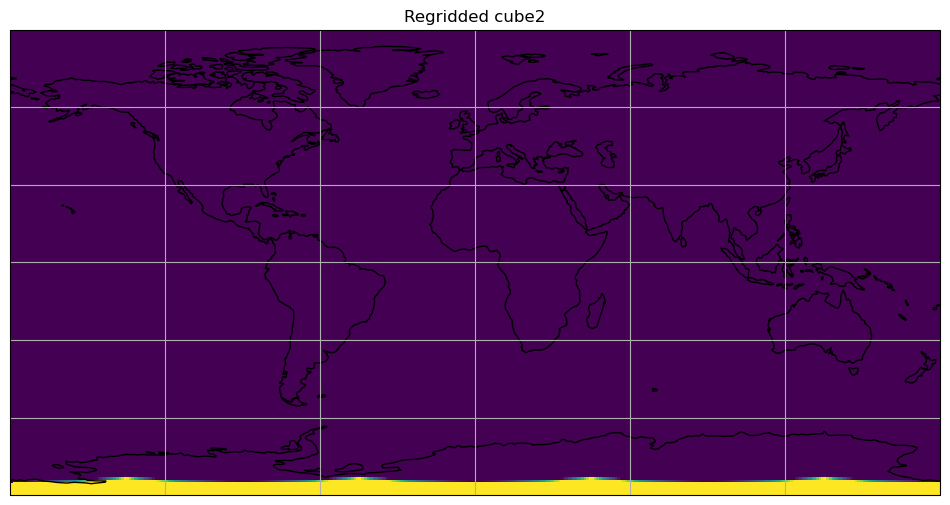

In [170]:
plt.figure(figsize=(12, 9))
iplt.pcolormesh(tx_cube2)
plt.title("Regridded cube2")
ax = plt.gca()
ax.coastlines()
ax.gridlines()
#ax.set_extent([-90, 70, 10, 80])

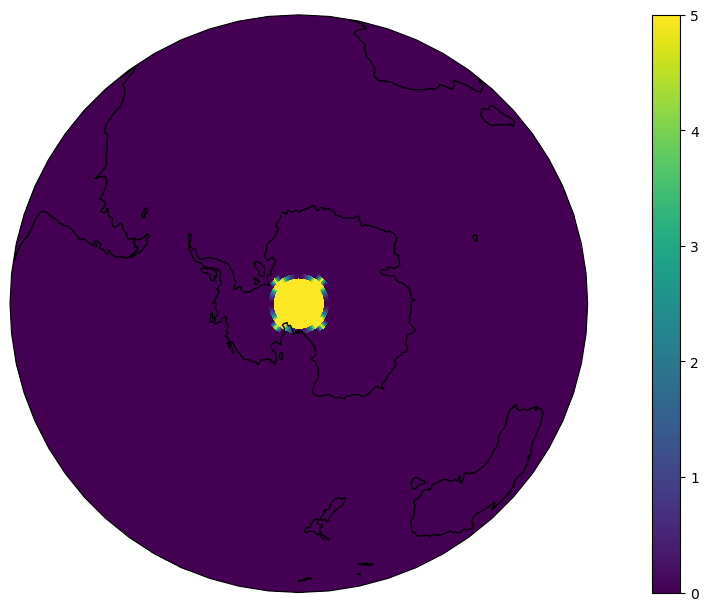

In [171]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.Orthographic(0, -90)}, layout='constrained')
fig.set_size_inches(14, 6)
im = ax.pcolormesh(tx_cube2.coord('longitude').points, tx_cube2.coord('latitude').points, tx_cube2.data, transform=ccrs.PlateCarree())
ax.coastlines()
plt.colorbar(im)

In [105]:
grid_areas = iris.analysis.cartography.area_weights(cube)

In [106]:
grid_areas

array([[1.07903992e+08, 1.07903992e+08, 1.07903992e+08, ...,
        1.07903992e+08, 1.07903992e+08, 1.07903992e+08],
       [3.23679108e+08, 3.23679108e+08, 3.23679108e+08, ...,
        3.23679108e+08, 3.23679108e+08, 3.23679108e+08],
       [5.39355628e+08, 5.39355628e+08, 5.39355628e+08, ...,
        5.39355628e+08, 5.39355628e+08, 5.39355628e+08],
       ...,
       [5.39355628e+08, 5.39355628e+08, 5.39355628e+08, ...,
        5.39355628e+08, 5.39355628e+08, 5.39355628e+08],
       [3.23679108e+08, 3.23679108e+08, 3.23679108e+08, ...,
        3.23679108e+08, 3.23679108e+08, 3.23679108e+08],
       [1.07903992e+08, 1.07903992e+08, 1.07903992e+08, ...,
        1.07903992e+08, 1.07903992e+08, 1.07903992e+08]])

In [172]:
def cube_integral(cube):
    grid_areas = iris.analysis.cartography.area_weights(cube)
    return (grid_areas * cube.data).sum()

In [173]:
cube_integral(cube2)

6174756076560.741

In [174]:
cube_integral(tx_cube2)

6175222723418.439

In [203]:

from iris.coords import DimCoord
from iris.cube import Cube

import numpy as np

cs = iris.coord_systems.GeogCS(6371229)
latitude = DimCoord(np.linspace(-89.5, 89.5, 180),
                    standard_name='latitude',
                    units='degrees',
                    coord_system=cs)
longitude = DimCoord(np.linspace(0.5, 359.5, 360),
                     standard_name='longitude',
                     units='degrees',
                     coord_system=cs)


latitude.guess_bounds()
longitude.guess_bounds()
cube = Cube(np.zeros((180, 360), np.float32),
            dim_coords_and_dims=[(latitude, 0),
                                 (longitude, 1)])

tx_cube2s = []
for pole_lat in np.linspace(90, 0, 4):
    print(pole_lat)
    cs2 = iris.coord_systems.RotatedGeogCS(pole_lat, 180, ellipsoid=cs)

    latitude2 = DimCoord(np.linspace(-89.5, 89.5, 180),
                         standard_name='latitude',
                         units='degrees',
                         coord_system=cs2)
    longitude2 = DimCoord(np.linspace(0.5, 359.5, 360),
                          standard_name='longitude',
                          units='degrees',
                          coord_system=cs2)
    latitude2.guess_bounds()
    longitude2.guess_bounds()

    cube2 = Cube(np.zeros((180, 360), np.float32),
                dim_coords_and_dims=[(latitude2, 0),
                                     (longitude2, 1)])

    cube2.data[85:95, 175:185] = 5
    scheme = ESMFAreaWeighted()
    tx_cube2 = cube2.regrid(cube, scheme)
    tx_cube2s.append(tx_cube2)

90.0
60.0
30.0
0.0


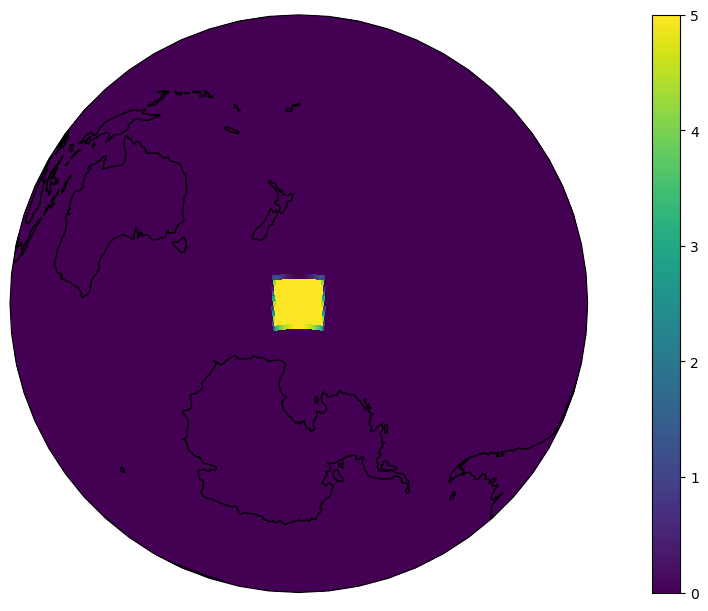

In [204]:
i = 2
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.Orthographic(180, - i * 30)}, layout='constrained')
fig.set_size_inches(14, 6)
im = ax.pcolormesh(tx_cube2s[i].coord('longitude').points, tx_cube2s[i].coord('latitude').points, tx_cube2s[i].data, transform=ccrs.PlateCarree())
ax.coastlines()
plt.colorbar(im)


In [205]:
for i, tx_cube2 in enumerate(tx_cube2s):
    print(f'percentage error for {i}: {np.abs(cube_integral(tx_cube2) - cube_integral(tx_cube2s[0])) / cube_integral(tx_cube2s[0]):.6f}%')


percentage error for 0: 0.000000%
percentage error for 1: 0.000019%
percentage error for 2: 0.000057%
percentage error for 3: 0.000076%


In [206]:
tx_cube2comb = tx_cube2s[0].copy()
for tx_cube2 in tx_cube2s[1:]:
    tx_cube2comb.data += tx_cube2.data

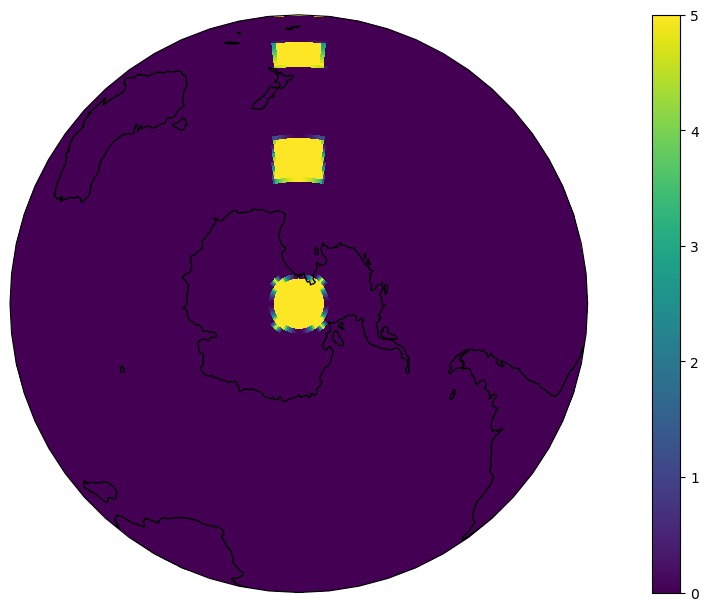

In [208]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.Orthographic(180, -90)}, layout='constrained')
fig.set_size_inches(14, 6)
im = ax.pcolormesh(tx_cube2comb.coord('longitude').points, tx_cube2comb.coord('latitude').points, tx_cube2comb.data, transform=ccrs.PlateCarree())
ax.coastlines()
plt.colorbar(im)


In [209]:
def gf_cube(cube, sigma=1):
    fcube = cube.copy()
    fcube.data = ndimage.gaussian_filter1d(fcube.data, sigma, axis=0) # <-there is a problem near the poles, I think because of this line.

    for i, y in enumerate(tx_cube2comb.coord('latitude').points):
        sigma_x = sigma / np.cos(np.pi * y / 180)
        if np.abs(y) > 89.6:
            continue
        fcube.data[i] = ndimage.gaussian_filter1d(fcube.data[i], sigma_x, mode='wrap')
    return fcube

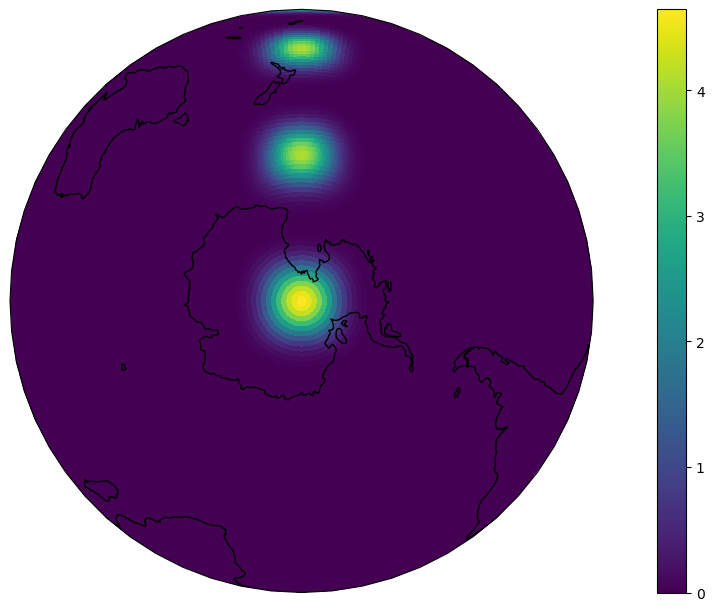

In [211]:
cube3 = gf_cube(tx_cube2comb, sigma=3)
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.Orthographic(180, -90)}, layout='constrained')
fig.set_size_inches(14, 6)
im = ax.pcolormesh(cube3.coord('longitude').points, cube3.coord('latitude').points, cube3.data, transform=ccrs.PlateCarree())
ax.coastlines()
plt.colorbar(im)

27.761%


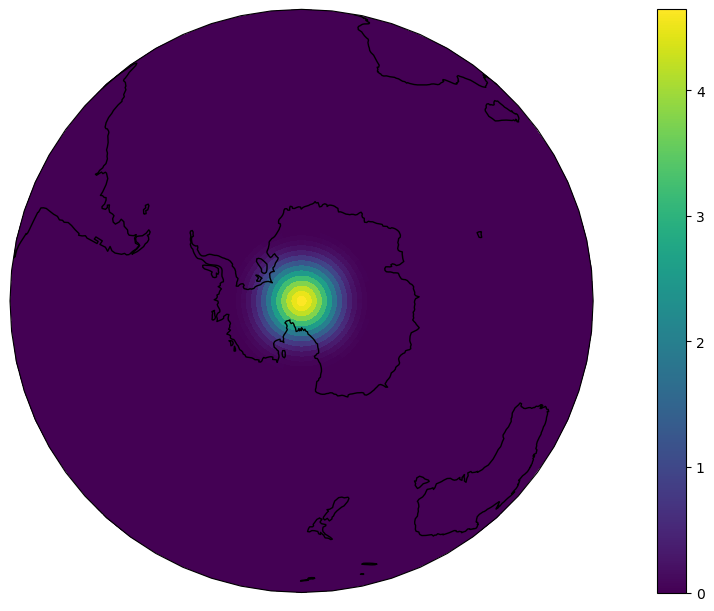

In [212]:


fcube0 = gf_cube(tx_cube2s[0], 3)

i = 3
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.Orthographic(0, i * -30)}, layout='constrained')
fig.set_size_inches(14, 6)
fcube = gf_cube(tx_cube2s[i], 3)
im = ax.pcolormesh(fcube.coord('longitude').points, fcube.coord('latitude').points, fcube.data, transform=ccrs.PlateCarree())
ax.coastlines()
plt.colorbar(im)
print(f'{100 * np.abs(cube_integral(fcube) - cube_integral(fcube0)) / cube_integral(fcube0):.3f}%')

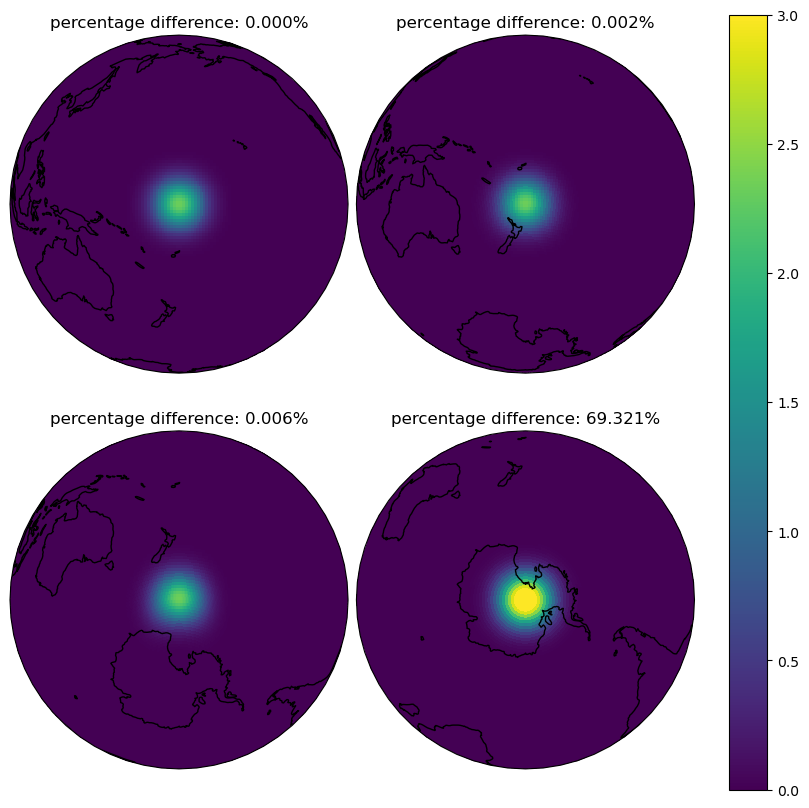

In [228]:
sigma = 5
fig = plt.figure(figsize=[8, 8], layout='constrained')
ax1 = fig.add_subplot(2, 2, 1, projection=ccrs.Orthographic(180, 0))
ax2 = fig.add_subplot(2, 2, 2, projection=ccrs.Orthographic(180, -30),
                      sharex=ax1, sharey=ax1)
ax3 = fig.add_subplot(2, 2, 3, projection=ccrs.Orthographic(180, -60),
                      sharex=ax1, sharey=ax1)
ax4 = fig.add_subplot(2, 2, 4, projection=ccrs.Orthographic(180, -90),
                      sharex=ax1, sharey=ax1)
fcube0 = gf_cube(tx_cube2s[0], sigma)

for ax, tx_cube2 in zip([ax1, ax2, ax3, ax4], tx_cube2s):
    fcube = gf_cube(tx_cube2, sigma)
    ax.set_title(f'percentage difference: {100 * np.abs(cube_integral(fcube) - cube_integral(fcube0)) / cube_integral(fcube0):.3f}%')
    im = ax.pcolormesh(fcube.coord('longitude').points, fcube.coord('latitude').points, fcube.data, transform=ccrs.PlateCarree(), vmin=0, vmax=3)
    ax.coastlines()
    
plt.colorbar(im, ax=[ax1, ax2, ax3, ax4])
    